# Build a bootstrap map

When evaluating the Teleconnections evaluation for a model, it is important to understand the concordance between the model and the observations.
If the CLI available is run, maps showing the differences beetwen the model and ERA5 will be generated.

A more accurate estimate of the statistical validity of the model and the observations can be obtained by building a bootstap map.
In order to do this, we first execute a bootstrap on the index timeseries of ERA5 and build regression maps based on this bootstrap.
Then, we evaluate the percentile for each pixel of these maps and build a mask, where the pixels of the model between the 5th and 95th percentile are considered concordant.
Then we can plot together the regression map for the model and the mask, to see where the model is concordant with the observations.

Let's start by evaluating the quantities needed. We will keep here a very low value of the bootstrap to perform just to show the concept. In a real case, we would need to run a bootstrap with a higher number of iterations to get a more accurate estimate of the concordance.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from aqua.diagnostics import ENSO

Let's start with ERA5 data, of which we need only the timeseries. We will set regrid to 1 deg to speed up the evaluation and the bootstrap.

In [3]:
tc_ERA = ENSO(catalog='obs', model='ERA5', exp='era5', source='monthly', regrid='r100', loglevel='WARNING')

In [4]:
tc_ERA.retrieve()
tc_ERA.compute_index()

We do the same for a model to analyze, already regridded to monthly, 1 deg resolution.

In [5]:
tc_model = ENSO(catalog='climatedt-phase1', model='IFS-NEMO', exp='ssp370', source='lra-r100-monthly', loglevel='WARNING')

In [6]:
tc_model.retrieve()
tc_model.compute_index()

2025-05-30 12:47:05 :: Regridder :: WARNING  -> Source grid path not found. Please provide a dataset.
2025-05-30 12:47:05 :: Reader :: WARNING  -> Issues in the Regridder() init: trying with data


For the model we evaluate the regression map and store it. The bootstrap procedure is available at the moment only for the full year regression, but the bootstrap methodology can be generalized with seasonal regression maps.

In [11]:
reg = tc_model.compute_regression()

The bootstrap is performed with two functions, `bootstrap_teleconnections` and `build_confidence_mask`.
The first one will perform the bootstrap, evaluate the regression maps for each iteration and at the end return the lower and upper percentiles of the regression maps.
The second function will build the mask based on the percentiles.

Let's import the necessary functions:

In [7]:
from aqua.diagnostics.teleconnections.bootstrap import bootstrap_teleconnections, build_confidence_mask

Let's evaluate the bootstrap, please be aware that this should be done in a proper computational node in a script. Here we are just showing the concept.

In [8]:
lower, upper = bootstrap_teleconnections(tc_model, tc_ERA, var='tos',
                                         n_bootstraps=10, concordance=0.05, statistic='regression', loglevel='DEBUG')

2025-05-30 12:47:44 :: Bootstrap teleconnections :: DEBUG    -> Reference teleconnection data: <xarray.Dataset> Size: 523MB
Dimensions:  (time: 1008, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2023-12-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    tos      (time, lat, lon) float64 523MB dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Apr 05 04:30:18 2024: cdo -O -s -f nc4 -z zip -cat /wor...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...
2025-05-30 12:47:44 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 1/10


2025-05-30 12:48:13 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 2/10
2025-05-30 12:48:36 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 3/10
2025-05-30 12:49:02 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 4/10
2025-05-30 12:49:27 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 5/10
2025-05-30 12:49:53 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 6/10
2025-05-30 12:50:19 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 7/10
2025-05-30 12:50:44 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 8/10
2025-05-30 12:51:10 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 9/10
2025-05-30 12:51:34 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 10/10
/LUMI_TYKKY_D6o4c7W/miniconda/envs/env1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
2025-05-30 12:52:08 :: Bootstrap teleconnections :: INFO     -> Bootstrap confidence intervals computed.


Let's plot together the two boundaries:

/LUMI_TYKKY_D6o4c7W/miniconda/envs/env1/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/LUMI_TYKKY_D6o4c7W/miniconda/envs/env1/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/LUMI_TYKKY_D6o4c7W/miniconda/envs/env1/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/LUMI_TYKKY_D6o4c7W/miniconda/envs/env1/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: Deprec

Text(0.5, 1.0, 'Lower 5% confidence interval')

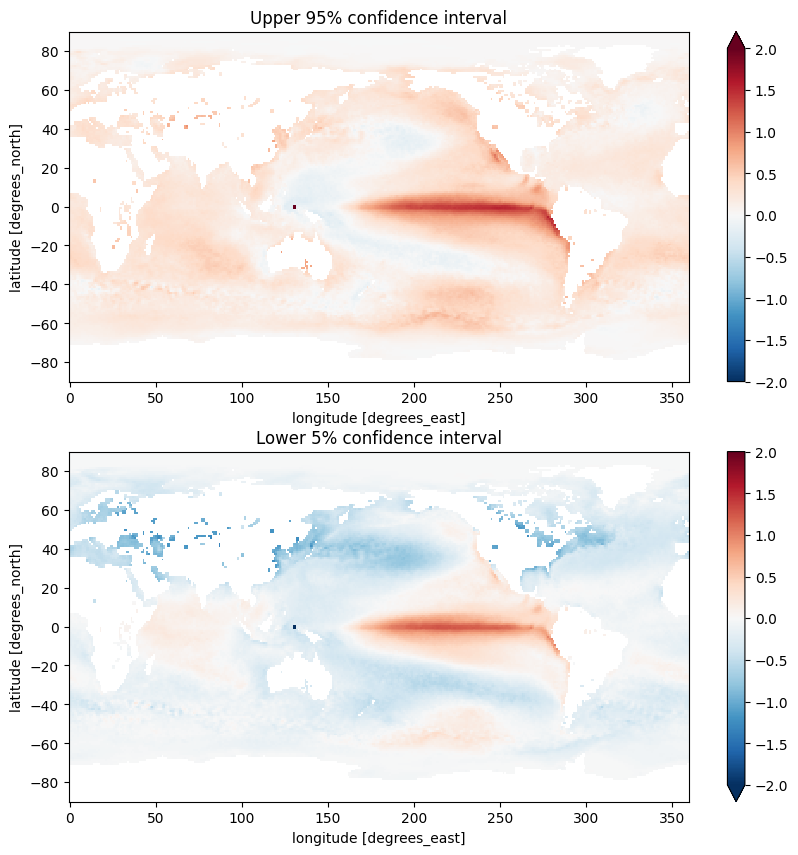

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

upper.plot(ax=ax[0], cmap='RdBu_r', vmin=-2, vmax=2)
ax[0].set_title('Upper 95% confidence interval')
lower.plot(ax=ax[1], cmap='RdBu_r', vmin=-2, vmax=2)
ax[1].set_title('Lower 5% confidence interval')

The mask is then built with the function `build_confidence_mask`.
By default the values are set in the regions where the model is concordant with the observations.
The `mask_concordance` flag can be used to selec the regions where the model is discordant with the observations.

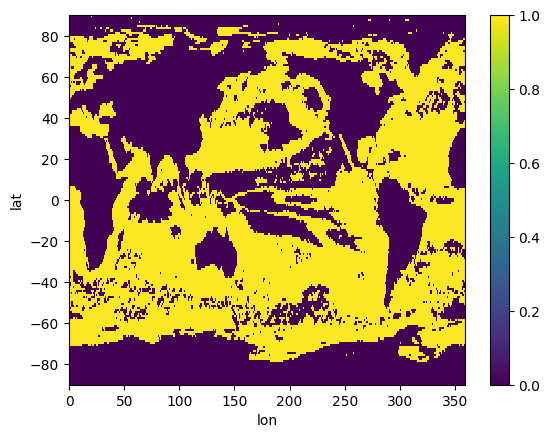

In [12]:
mask = build_confidence_mask(map=reg, lower=lower, upper=upper, mask_concordance=True)
mask.plot()

We can finally plot together the regression map with the mask to see where the model is concordant with the observations.

In [ ]:
#from aqua.graphics import plot_single_map
#from aqua.util import add_cyclic_lon

#fig, ax = plot_single_map(reg, transform_first=True, return_fig=True, vmin=-1.4, vmax=1.4)

#mask = add_cyclic_lon(mask) # To make sure the mask is cyclic
#mask.where(mask == 1).plot.contourf(levels=[0, 1], colors='none', hatches=['....', ''], add_colorbar=False, ax=ax)

Finally we can do a simple plot to check the details of the procedure:

Text(0.5, 1.0, 'Upper percentile')

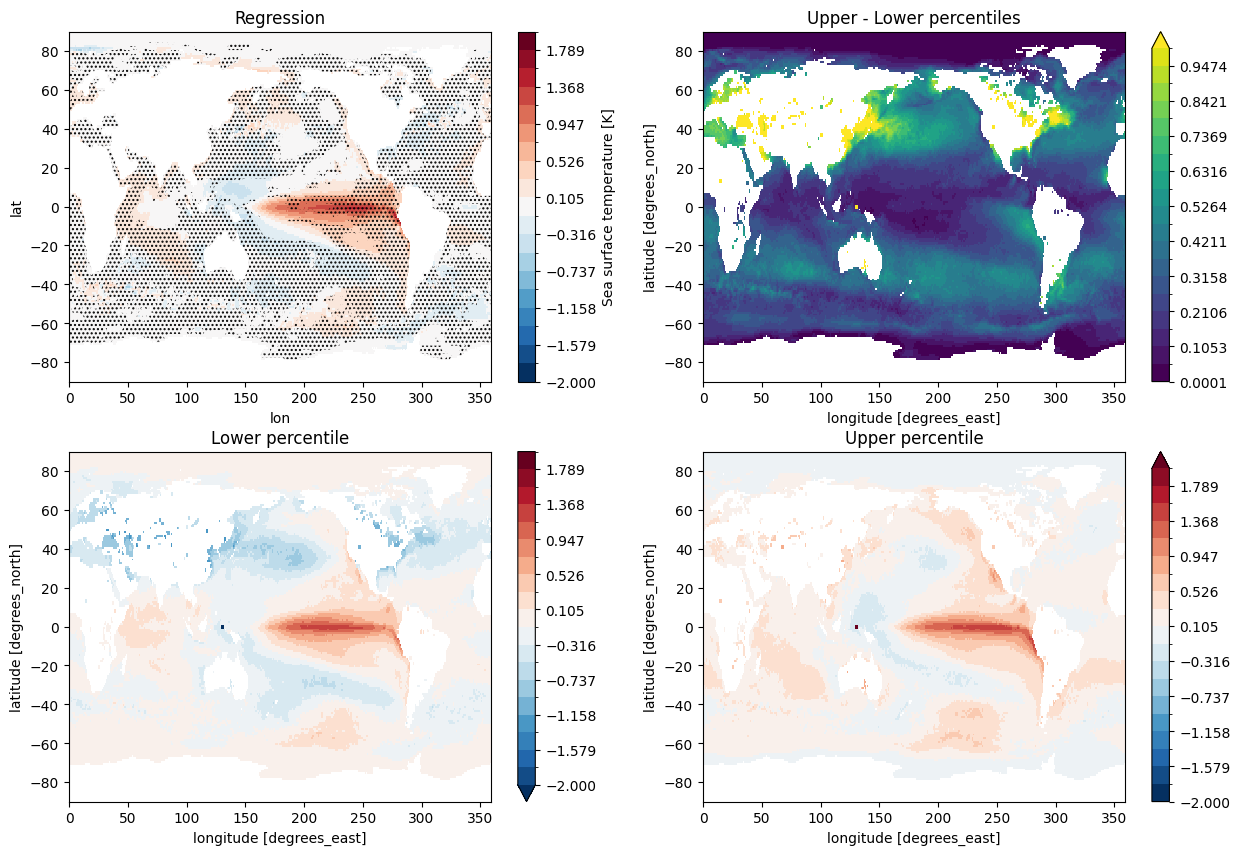

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot map and mask on the first row
reg.plot.pcolormesh(ax=axs[0,0], vmin=-2., vmax=2., cmap='RdBu_r', levels=20)
mask.where(mask == 1).plot.contourf(levels=[0, 1], colors='none', hatches=['....', ''], add_colorbar=False, ax=axs[0,0])

# Plot u-l on the first row
(upper - lower).plot(ax=axs[0, 1], levels=20, vmax=1.)

# Plot lower and upper on the second row
lower.plot(ax=axs[1, 0], vmin=-2., vmax=2., cmap='RdBu_r', levels=20)
upper.plot(ax=axs[1, 1], vmin=-2., vmax=2., cmap='RdBu_r', levels=20)

axs[0, 0].set_title('Regression')
axs[0, 1].set_title('Upper - Lower percentiles')
axs[1, 0].set_title('Lower percentile')
axs[1, 1].set_title('Upper percentile')

As we can see a bigger number of iterations is needed to get a more accurate estimate of the concordance between the model and the observations.